<a href="https://www.kaggle.com/code/vidhikishorwaghela/brain-tumor-detection-96-accuracy?scriptVersionId=141270738" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### STEP 1: IMPORTING ALL THE NECESARY LIBRARIES:

The code starts by importing the required libraries for data manipulation, visualization, and building the Convolutional Neural Network (CNN) model with highest possible accuracy using tensorflow.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout


### STEP 2: SETTING UP THE DATASET PATHS AND DIRECTORIES:


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set the path to the dataset
dataset_path = "/content/drive/MyDrive/Dataset"

# Define the training and testing directories
train_dir = "/content/drive/MyDrive/Dataset/Training"
test_dir = "/content/drive/MyDrive/Dataset/Testing"

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]


### STEP 3: LOADING AND PREPROCESSING THE DATASET:

1. The code reads the images from each category in the training directory, counts the number of images in each category, and creates a Pandas DataFrame (***train_df***) to store the image filenames, corresponding categories, and counts.

2. A bar plot is generated to visualize the distribution of tumor types in the training dataset.


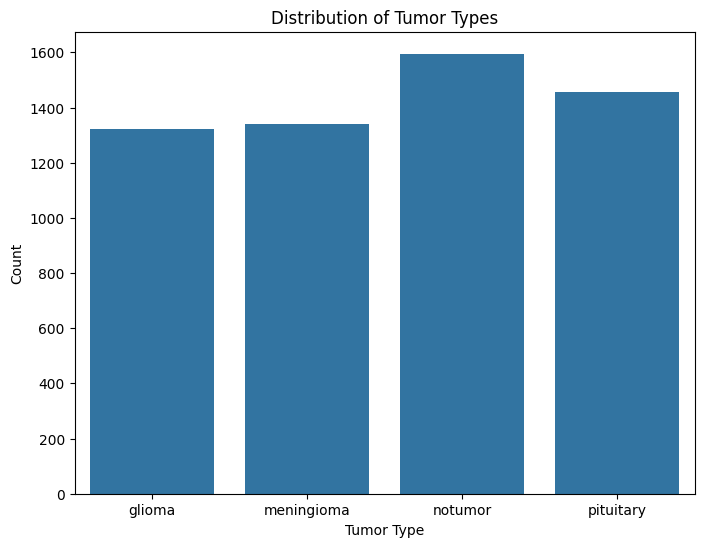

In [4]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()


### STEP 4: VISUALIZING IMAGES FOR EACH TUMOR TYPES:

Here, the code displays sample images for each tumor type using a grid of subplots.


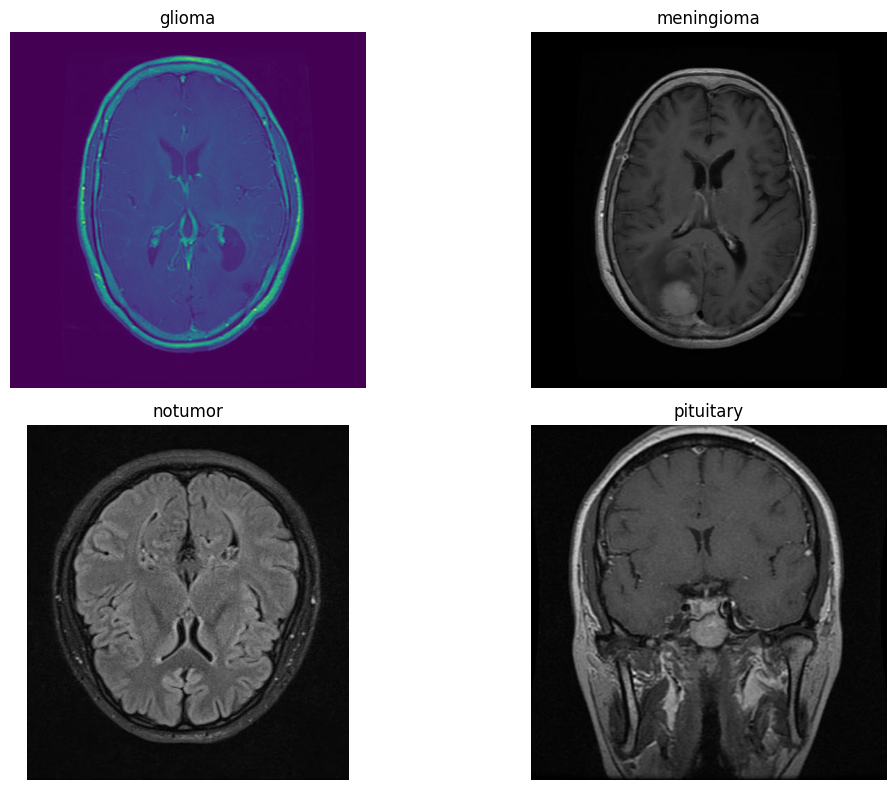

In [5]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [7]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


**DATA AUGMENTATION** is performed using ***ImageDataGenerator*** class from Keras. It applies various transformations to the training imags to artificially increase the size of the dataset and improve the generalization. The aumentation paramters include rescaling the pixel values, rotation, shifting, shearing, zooming and flipping. The ***train_generator*** is created using the augmented data, and the ***test_generator*** is created with only pixel rescaling for the test dataset.

In [11]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1. The model architecture is defined using a sequential model (**Sequential class**). It consists of a series of convolutional (**Conv2D**) and max pooling (**MaxPooling2D**) layers, followed by a **flattening layer**, two fully connected (**Dense**) layers, and a **dropout layer for regularization**.
2. The activation function used for the convolutional layers is **ReLU**, except for the last dense layer, where **softmax activation** is used to output class probabilities.
3. The model is compiled with the **Adam optimizer**, which is an adaptive learning rate optimization algorithm. The loss function used is **categorical cross-entropy**, suitable for multi-class classification problems with **one-hot encoded labels**.
4. The accuracy metric is also specified to monitor the model's performance during training.

In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1945s 11s/step - accuracy: 0.4634 - loss: 1.1406 - val_accuracy: 0.6820 - val_loss: 0.8759
Epoch 2/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 4:03 1s/step - accuracy: 0.7812 - loss: 0.7993

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 32s 170ms/step - accuracy: 0.7812 - loss: 0.7993 - val_accuracy: 0.6758 - val_loss: 0.8834
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.6914 - loss: 0.7644 - val_accuracy: 0.6359 - val_loss: 0.9478
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.7500 - loss: 0.6743 - val_accuracy: 0.6016 - val_loss: 1.0275
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.7623 - loss: 0.6068 - val_accuracy: 0.4727 - val_loss: 1.5994
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.7188 - loss: 0.6481 - val_accuracy: 0.4531 - val_loss: 1.8031
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.7653 - loss: 0.5952 - val_accuracy: 0.7602 - val_loss: 0.5720
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.7500 - loss: 0.5354 - val_accuracy: 0.7742 - val_loss: 0.5663
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.8114 - loss: 0.4937 - val_accurac

The model is trained using the **fit** method. The ***train_generator*** provides the **training data**, and the ***test_generator*** provides the **validation data**. The ***steps_per_epoch*** and ***validation_steps*** are set to ensure that the entire training and validation datasets are processed in one epoch. The training progress and performance metrics are stored in the history object.

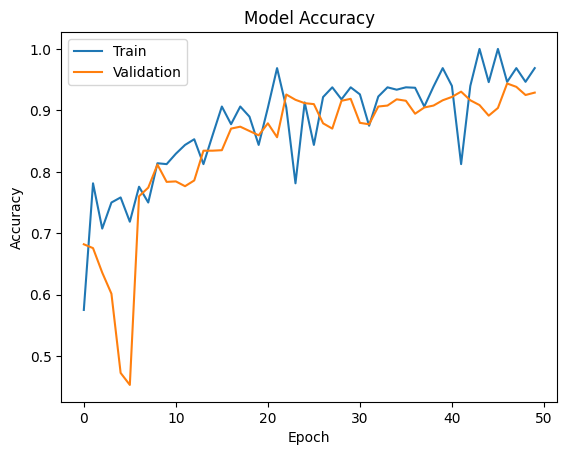

In [13]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

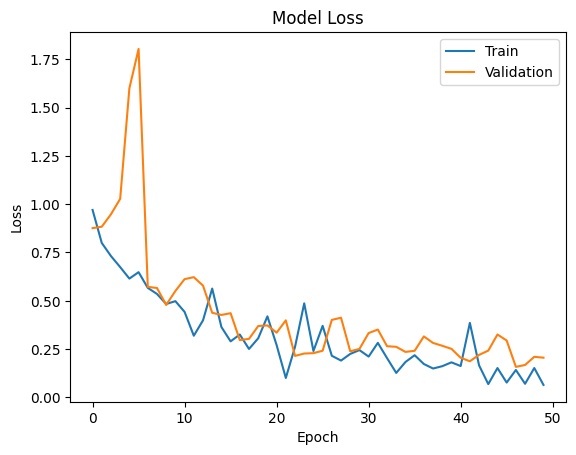

In [14]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 543ms/step - accuracy: 0.8937 - loss: 0.2921
Test Loss: 0.2057231217622757
Test Accuracy: 0.928906261920929


41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 630ms/step


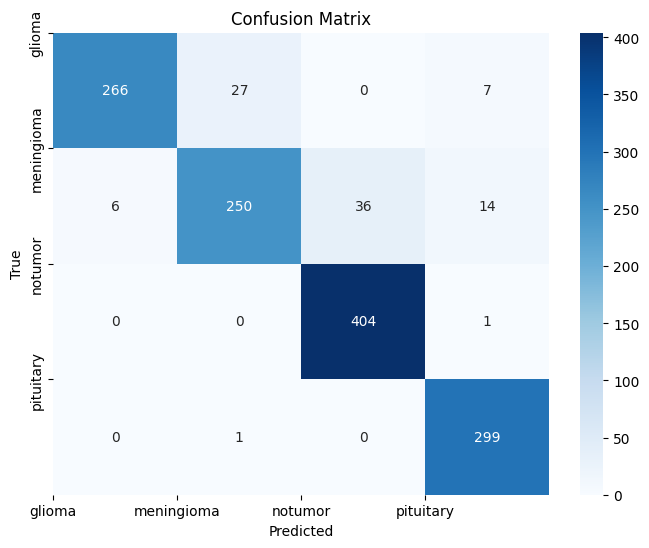

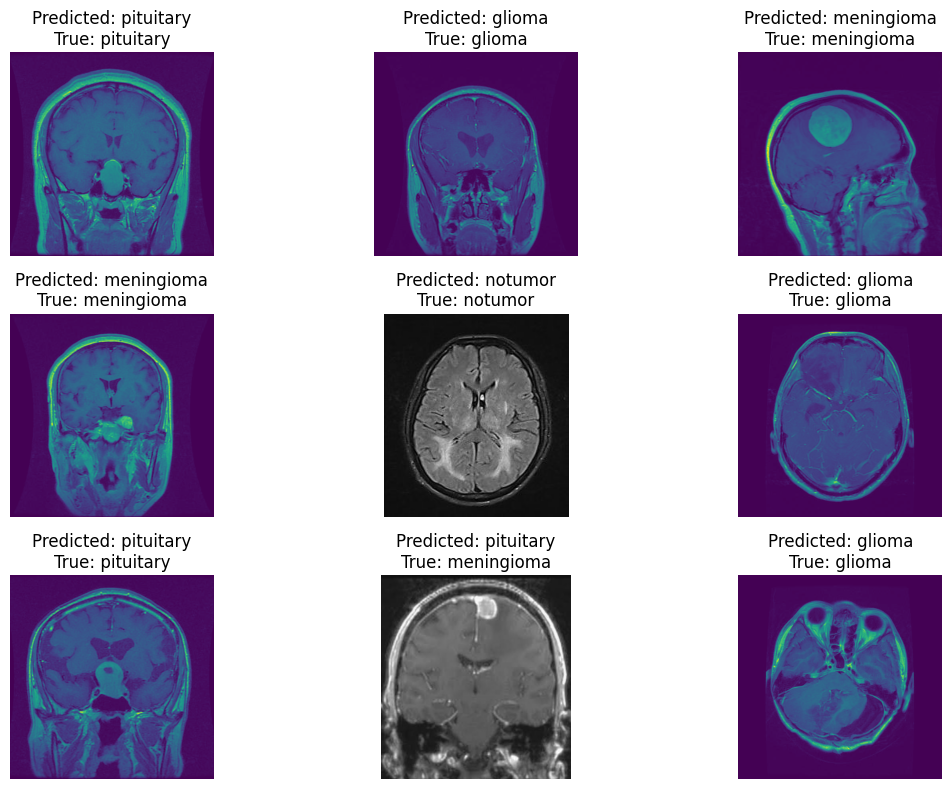

In [16]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Class: glioma
Precision: 0.9779411764705882
Recall: 0.8866666666666667
F1-Score: 0.9300699300699301

Class: meningioma
Precision: 0.8992805755395683
Recall: 0.8169934640522876
F1-Score: 0.8561643835616439

Class: notumor
Precision: 0.9181818181818182
Recall: 0.9975308641975309
F1-Score: 0.9562130177514794

Class: pituitary
Precision: 0.9314641744548287
Recall: 0.9966666666666667
F1-Score: 0.9629629629629629



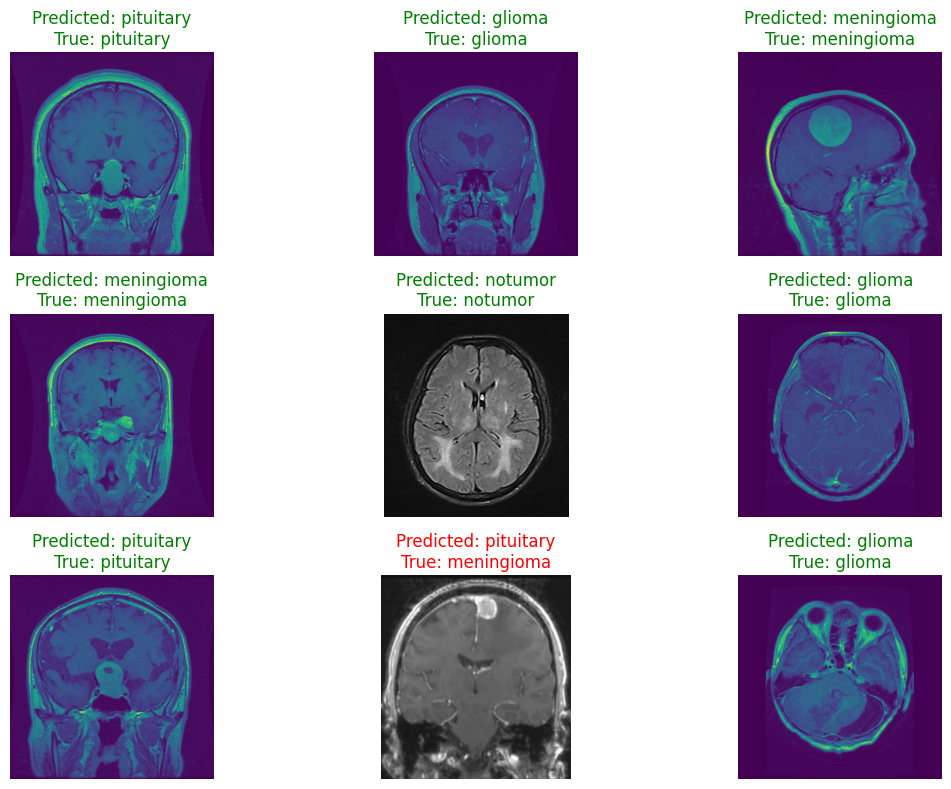

In [17]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [21]:
# Save the trained model
model.save("brain_tumor_detection_model.keras")